### Load Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import h5py
import os

from PIL import Image



# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)


2024-04-18 15:27:30.127214: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 15:27:30.160017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 15:27:30.160045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 15:27:30.160944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 15:27:30.166496: I tensorflow/core/platform/cpu_feature_guar

### Load and preprocess data

In [2]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)[:5000]
    boxes = np.array(boxes)[:5000]


image_normalized = (images + 1e-9) / 9.26
normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized

probabilities = np.array(normalized_boxes[:, :, :-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)


2024-04-18 15:27:35.151141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21568 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


### Model layout and definition

In [3]:
input_shape = (64,64,1)
num_classes = 280
num_coordinates = 4

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
num_epochs = 100

### Load saved weights

In [66]:
loaded_model = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/Sweep Weights/Train and Val/glamorous-sweep-7.h5")

### Post Training processing for furthur analysis

In [67]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
dataset = dataset.batch(5000)
inputs,targets = next(iter(dataset))
output =loaded_model.predict(inputs)

157/157 [==============================] - 1s 8ms/step


In [65]:
import tensorflow as tf

r = np.random.randint(0,5000)
tensor1 = tf.constant(targets['x_boxes_reshape'][r], dtype=tf.float64)

tensor2 = tf.constant(output[1][r], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 1.4689214515124013e-05


### Visualisation of Predictions Against Labels

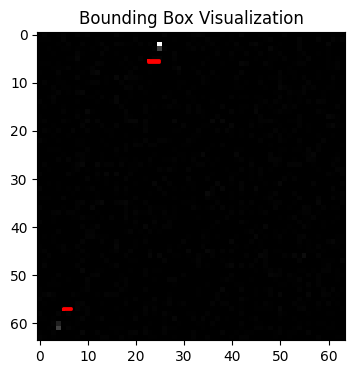

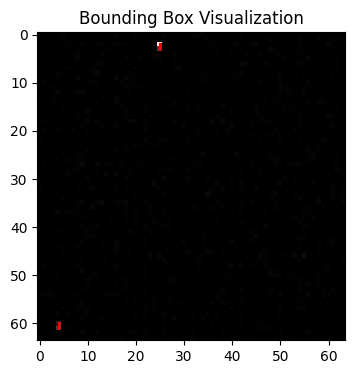

In [87]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,200)
# probabilities = tf.convert_to_tensor(output[0][t,:])
# t = 590
visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]),tf.convert_to_tensor(output[0][t,0,:,:]), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction


### Model Evaluation

1) Create Binary masks

In [68]:
# import numpy as np

def create_binary_mask_from_boxes(boxes, image_shape):
    binary_mask = np.zeros(image_shape[:2], dtype=np.uint8)  # assuming image_shape is (height, width)
    for box in boxes:
        # Scale the box coordinates to the image size
        x_min, y_min, x_max, y_max = box
        x_min = int(x_min * image_shape[1])
        x_max = int(x_max * image_shape[1])
        y_min = int(y_min * image_shape[0])
        y_max = int(y_max * image_shape[0])
        binary_mask[y_min:y_max, x_min:x_max] = 1
    return binary_mask

# Assume 'output' is your model prediction output and has a shape (N, 1, num_boxes, 4)
# Let's also assume 'output[0]' contains the confidence scores, and we only take boxes with confidence > 0.5
confidence_threshold = 0.5
image_shape = (64, 64, 1)

# binary_prediction_masks = []
# for i in range(len(output[0])):  # loop through all the predictions
#     confidences = output[0][i, 0, :, :]  # assuming the confidence scores are the first element in the last dimension
#     boxes = output[1][i, 0, :, :]  # extract all the bounding boxes for the i-th prediction
#     high_confidence_indices = np.where(confidences > confidence_threshold)[0]
#     selected_boxes = boxes[high_confidence_indices]
    
#     # Now create the binary mask from these selected boxes
#     binary_mask = create_binary_mask_from_boxes(selected_boxes, image_shape)
#     binary_prediction_masks.append(binary_mask)


# image_shape = (64, 64, 1)  # Update this if needed

# binary_ground_truth_masks = []
# for i in range(len(boxes_np)):
#     # No confidence threshold needed for ground truth, so we use all boxes
#     gt_boxes = boxes_np[i, 0, :, :]  # Get all boxes for the i-th ground truth

#     # We assume all boxes in the ground truth are valid, so no need to filter by confidence
#     binary_ground_truth_mask = create_binary_mask_from_boxes(gt_boxes, image_shape)
#     binary_ground_truth_masks.append(binary_ground_truth_mask)



import numpy as np
from skimage.measure import label
import matplotlib.pyplot as plt
import tensorflow as tf

# Your model's output, output[0] should contain confidence scores, output[1] the bounding boxes
# boxes_np should contain ground truth boxes
# image_shape should be the shape of your input images to the model

# Define NMS function
def non_max_suppression(boxes, scores, iou_threshold):
    if len(boxes) == 0:
        return [], []
    # Convert to a numpy array for vectorized operations
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Get the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes and sort by score
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_threshold)[0]
        order = order[inds + 1]

    return boxes[keep], scores[keep]

# Define IoU computation
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# Apply NMS and create binary masks from the filtered boxes
binary_prediction_masks = []
for i in range(output[0].shape[0]):
    confidences = output[0][i, 0, :, 0]
    boxes = output[1][i, 0, :, :]
    filtered_boxes, filtered_scores = non_max_suppression(boxes, confidences, iou_threshold=0.5)
    binary_mask = create_binary_mask_from_boxes(filtered_boxes, image_shape[:2])
    binary_prediction_masks.append(binary_mask)

# Create binary masks from ground truth
binary_ground_truth_masks = []
for i in range(len(boxes_np)):
    gt_boxes = boxes_np[i, 0, :, :]
    binary_ground_truth_mask = create_binary_mask_from_boxes(gt_boxes, image_shape[:2])
    binary_ground_truth_masks.append(binary_ground_truth_mask)

In [8]:
import numpy as np
from skimage.measure import label
import matplotlib.pyplot as plt
import tensorflow as tf

def create_binary_mask_from_boxes(boxes, image_shape):
    binary_mask = np.zeros(image_shape[:2], dtype=np.uint8)  # assuming image_shape is (height, width)
    for box in boxes:
        # Scale the box coordinates to the image size
        x_min, y_min, x_max, y_max = box
        x_min = int(x_min * image_shape[1])
        x_max = int(x_max * image_shape[1])
        y_min = int(y_min * image_shape[0])
        y_max = int(y_max * image_shape[0])
        binary_mask[y_min:y_max, x_min:x_max] = 1
    return binary_mask

# Assume 'output' is your model prediction output and has a shape (N, 1, num_boxes, 4)
# Let's also assume 'output[0]' contains the confidence scores, and we only take boxes with confidence > 0.5
confidence_threshold = 0.5
image_shape = (64, 64, 1)

# Define NMS function
def non_max_suppression(boxes, scores, iou_threshold):
    if len(boxes) == 0:
        return [], []
    # Convert to a numpy array for vectorized operations
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Get the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes and sort by score
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_threshold)[0]
        order = order[inds + 1]

    return boxes[keep], scores[keep]

# Define IoU computation
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# Apply NMS and create binary masks from the filtered boxes
binary_prediction_masks = []
for i in range(output[0].shape[0]):
    confidences = output[0][i, 0, :, 0]
    boxes = output[1][i, 0, :, :]
    filtered_boxes, filtered_scores = non_max_suppression(boxes, confidences, iou_threshold=0.5)
    binary_mask = create_binary_mask_from_boxes(filtered_boxes, image_shape[:2])
    binary_prediction_masks.append(binary_mask)

# Create binary masks from ground truth
binary_ground_truth_masks = []
for i in range(len(boxes_np)):
    gt_boxes = boxes_np[i, 0, :, :]
    binary_ground_truth_mask = create_binary_mask_from_boxes(gt_boxes, image_shape[:2])
    binary_ground_truth_masks.append(binary_ground_truth_mask)
    
from skimage.measure import label

# Assuming binary_prediction_masks is a list of binary masks for the predictions
labeled_pred_masks = [label(mask) for mask in binary_prediction_masks]

# Assuming binary_ground_truth_masks is a list of binary masks for the ground truth
labeled_gt_masks = [label(mask) for mask in binary_ground_truth_masks]


In [9]:

def find_matches(labeled_pred_masks, labeled_gt_masks, threshold=0.5):  # Lowered threshold for testing
    matches = []
    for i, pred_mask in enumerate(labeled_pred_masks):
        for j, gt_mask in enumerate(labeled_gt_masks):
            iou = compute_iou(pred_mask, gt_mask)
            if iou > threshold:
                matches.append((i, j))
                print(f"Match found between prediction {i} and ground truth {j} with IoU: {iou}")  # Debug print
    return matches

# Recalculate matches with debugging and a lower IoU threshold
matches = find_matches(labeled_pred_masks, labeled_gt_masks)
print("Total matches found:", len(matches))


# True Positives (TP): Predicted components that match ground truth components
TP = len(matches)

# False Positives (FP): Predicted components that don't match any ground truth component
total_pred_components = len(np.unique(labeled_pred_masks)) - 1  # minus 1 to exclude background
FP = total_pred_components - TP

# False Negatives (FN): Ground truth components that weren't matched by predicted components
total_gt_components = len(np.unique(labeled_gt_masks)) - 1  # minus 1 to exclude background
FN = total_gt_components - TP


Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

Match found between prediction 87 and ground truth 179 with IoU: 1.0
Match found between prediction 207 and ground truth 207 with IoU: 1.0
Match found between prediction 326 and ground truth 326 with IoU: 0.5714285714285714
Match found between prediction 352 and ground truth 77 with IoU: 1.0
Match found between prediction 462 and ground truth 66 with IoU: 0.6666666666666666
Match found between prediction 511 and ground truth 511 with IoU: 0.7058823529411765
Match found between prediction 549 and ground truth 549 with IoU: 0.6666666666666666
Match found between prediction 807 and ground truth 807 with IoU: 0.5106382978723404
Match found between prediction 976 and ground truth 359 with IoU: 0.5316455696202531
Total matches found: 9


In [ ]:
# import os

# def create_directory_if_not_exists(directory_path):
#     """
#     Create a directory if it doesn't exist.

#     Args:
#     - directory_path (str): Path of the directory to be created.
#     """
#     if not os.path.exists(directory_path):
#         try:
#             os.makedirs(directory_path)
#             print(f"Directory '{directory_path}' created successfully.")
#         except OSError as e:
#             print(f"Error creating directory '{directory_path}': {e}")
#     else:
#         print(f"Directory '{directory_path}' already exists.")

In [ ]:
# import os

# def create_directory_if_not_exists(directory_path):
#     """
#     Create a directory if it doesn't exist.

#     Args:
#     - directory_path (str): Path of the directory to be created.
#     """
#     if not os.path.exists(directory_path):
#         try:
#             os.makedirs(directory_path)
#             print(f"Directory '{directory_path}' created successfully.")
#         except OSError as e:
#             print(f"Error creating directory '{directory_path}': {e}")
#     else:
#         print(f"Directory '{directory_path}' already exists.")

In [69]:
# from skimage.measure import label

# # Assuming binary_prediction_masks is a list of binary masks for the predictions
# labeled_pred_masks = [label(mask) for mask in binary_prediction_masks]

# # Assuming binary_ground_truth_masks is a list of binary masks for the ground truth
# labeled_gt_masks = [label(mask) for mask in binary_ground_truth_masks]


In [10]:

# from skimage.metrics import structural_similarity as ssim

# def match_components(labeled_pred, labeled_gt):
#     matches = []
#     for pred_label in np.unique(labeled_pred)[1:]:  # Skip the background label '0'
#         pred_mask = labeled_pred == pred_label
#         for gt_label in np.unique(labeled_gt)[1:]:
#             gt_mask = labeled_gt == gt_label
#             iou = compute_iou(pred_mask, gt_mask)
#             if iou > 0.5:  # IoU threshold
#                 matches.append((pred_label, gt_label))
#                 break  # Assuming one-to-one matching
#     return matches



# matches = match_components(labeled_pred_masks, labeled_gt_masks)






3) Compute IoU and Find Matches

In [71]:
# def compute_iou(mask1, mask2):
#     intersection = np.logical_and(mask1, mask2).sum()
#     union = np.logical_or(mask1, mask2).sum()
#     iou = intersection / union if union != 0 else 0
# #     return iou

# def find_matches(labeled_pred_masks, labeled_gt_masks, threshold=0.5):  # Lowered threshold for testing
#     matches = []
#     for i, pred_mask in enumerate(labeled_pred_masks):
#         for j, gt_mask in enumerate(labeled_gt_masks):
#             iou = compute_iou(pred_mask, gt_mask)
#             if iou > threshold:
#                 matches.append((i, j))
#                 print(f"Match found between prediction {i} and ground truth {j} with IoU: {iou}")  # Debug print
#     return matches

# # Recalculate matches with debugging and a lower IoU threshold
# matches = find_matches(labeled_pred_masks, labeled_gt_masks)
# print("Total matches found:", len(matches))


Match found between prediction 87 and ground truth 179 with IoU: 1.0
Match found between prediction 207 and ground truth 207 with IoU: 1.0
Match found between prediction 326 and ground truth 326 with IoU: 0.5714285714285714
Match found between prediction 352 and ground truth 77 with IoU: 1.0
Match found between prediction 462 and ground truth 66 with IoU: 0.6666666666666666
Match found between prediction 511 and ground truth 511 with IoU: 0.7058823529411765
Match found between prediction 549 and ground truth 549 with IoU: 0.6666666666666666
Match found between prediction 807 and ground truth 807 with IoU: 0.5106382978723404
Match found between prediction 976 and ground truth 359 with IoU: 0.5316455696202531
Total matches found: 9


In [72]:
# # True Positives (TP): Predicted components that match ground truth components
# TP = len(matches)

# # False Positives (FP): Predicted components that don't match any ground truth component
# total_pred_components = len(np.unique(labeled_pred_masks)) - 1  # minus 1 to exclude background
# FP = total_pred_components - TP

# # False Negatives (FN): Ground truth components that weren't matched by predicted components
# total_gt_components = len(np.unique(labeled_gt_masks)) - 1  # minus 1 to exclude background
# FN = total_gt_components - TP


# Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
# F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0


In [10]:
# Print metrics
print(f"Precision: {Precision:.2f}, Recall: {Recall:.2f}, F1 Score: {F1:.2f}")


Precision: 0.16, Recall: 0.17, F1 Score: 0.17


In [11]:
# Debug print the values
print(f"Total Predictions (Components): {total_pred_components}")
print(f"Total Ground Truths (Components): {total_gt_components}")
print(f"True Positives (Matches found): {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")


Total Predictions (Components): 56
Total Ground Truths (Components): 53
True Positives (Matches found): 9
False Positives: 47
False Negatives: 44


In [12]:
print("Total Predictions:", sum(len(np.unique(mask)) - 1 for mask in labeled_pred_masks))
print("Total Ground Truths:", sum(len(np.unique(mask)) - 1 for mask in labeled_gt_masks))
print("Matches Found:", len(matches))


Total Predictions: 106928
Total Ground Truths: 89871
Matches Found: 9


ValueError: not enough values to unpack (expected 3, got 2)

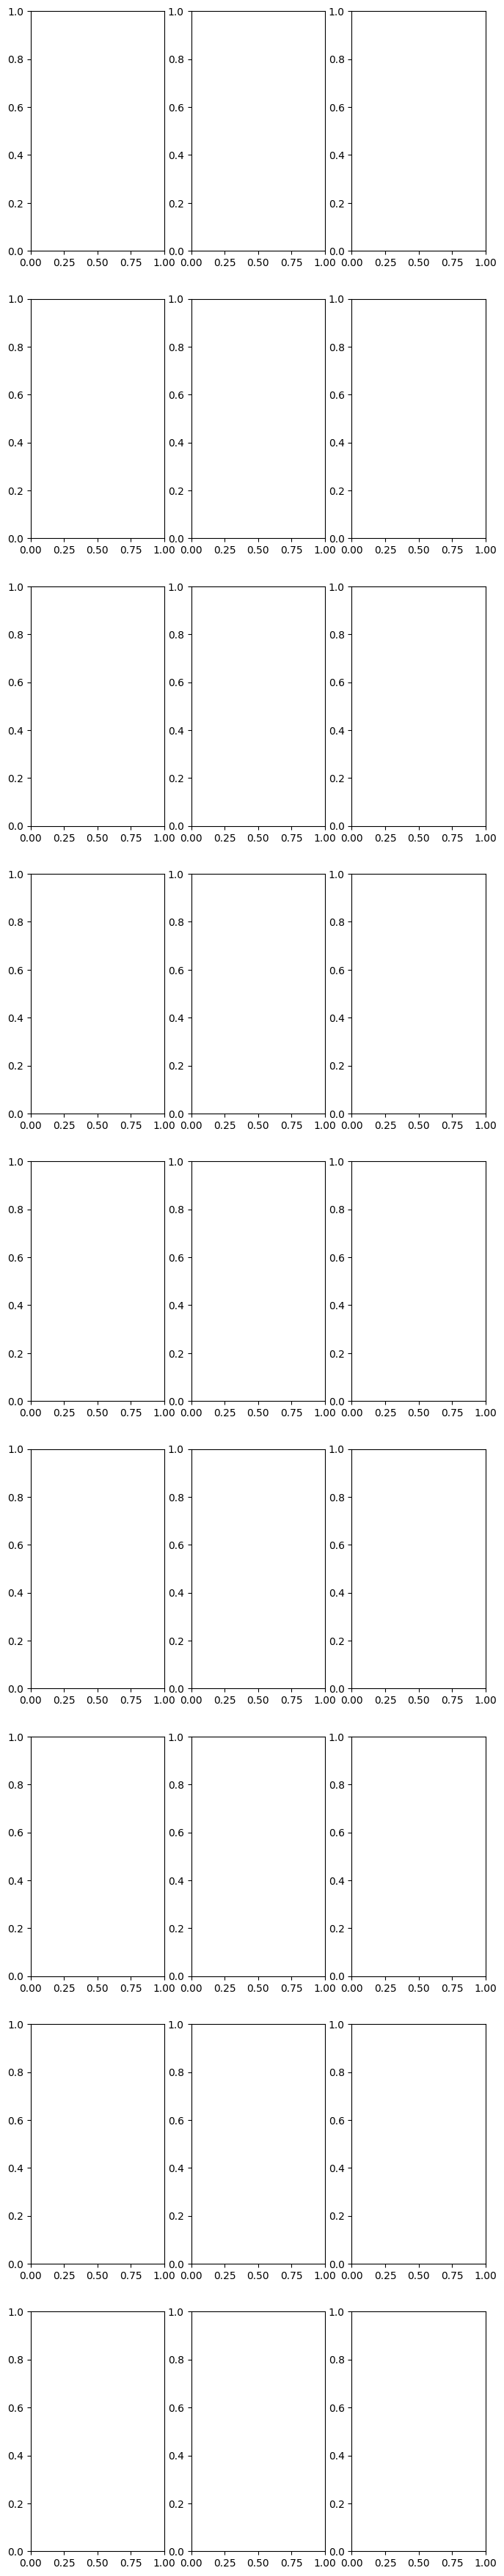

In [15]:
# import matplotlib.pyplot as plt

# def visualize_matches(images, labeled_pred_masks, labeled_gt_masks, matches, num_samples=10):
#     sample_matches = matches[:num_samples]
#     fig, axes = plt.subplots(num_samples, 3, figsize=(8, 5 * num_samples))
#     for idx, (pred_index, gt_index) in enumerate(sample_matches):
#         axes[idx, 0].imshow(images[idx], cmap='gray')
#         axes[idx, 0].set_title('Original Image')
#         axes[idx, 1].imshow(labeled_pred_masks[pred_index], cmap='nipy_spectral')
#         axes[idx, 1].set_title(f'Predicted Mask (IoU: {compute_iou(labeled_pred_masks[pred_index], labeled_gt_masks[gt_index]):.2f})')
#         axes[idx, 2].imshow(labeled_gt_masks[gt_index], cmap='nipy_spectral')
#         axes[idx, 2].set_title('Ground Truth Mask')
#         for ax in axes[idx]:
#             ax.axis('off')
#     plt.tight_layout()
#     plt.show()
def visualize_matches(images, labeled_pred_masks, labeled_gt_masks, matches, num_samples=10):
    num_samples = min(num_samples, len(matches))  # Adjust number of samples based on available matches
    indices = np.arange(len(matches))
    if len(matches) > num_samples:
        sample_indices = np.random.choice(indices, size=num_samples, replace=False)
    else:
        sample_indices = indices

    sample_matches = [matches[i] for i in sample_indices]

    fig, axes = plt.subplots(num_samples, 3, figsize=(8, 5 * num_samples))
    for idx, (pred_index, gt_index, iou) in enumerate(sample_matches):
        img_index = idx  # Adjust if images list doesn't align directly with sample indices
        axes[idx, 0].imshow(images[img_index], cmap='gray')
        axes[idx, 0].set_title('Original Image')
        axes[idx, 1].imshow(labeled_pred_masks[pred_index], cmap='nipy_spectral')
        axes[idx, 1].set_title(f'Predicted Mask (IoU: {iou:.2f})')
        axes[idx, 2].imshow(labeled_gt_masks[gt_index], cmap='nipy_spectral')
        axes[idx, 2].set_title('Ground Truth Mask')
        for ax in axes[idx]:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# You need to ensure that the 'matches' are index pairs (pred_index, gt_index) that can be passed to np.random.choice.
# If 'matches' is not a simple array or needs a specific handling for random sampling, adjust the code accordingly.


# Assuming you have an array or list `images` corresponding to the matches
visualize_matches(images_np, tf.convert_to_tensor(labeled_pred_masks), tf.convert_to_tensor(labeled_gt_masks), matches)




In [5]:
# import os

# def create_directory_if_not_exists(directory_path):
#     """
#     Create a directory if it doesn't exist.

#     Args:
#     - directory_path (str): Path of the directory to be created.
#     """
#     if not os.path.exists(directory_path):
#         try:
#             os.makedirs(directory_path)
#             print(f"Directory '{directory_path}' created successfully.")
#         except OSError as e:
#             print(f"Error creating directory '{directory_path}': {e}")
#     else:
#         print(f"Directory '{directory_path}' already exists.")

In [7]:
# import re
# savepath = "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/ValidationResults/"
# path = "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/ValidationData-20231107T163458Z-001/"
# # savepath = '/home/m3-learning/Documents/myML/ValidationResults/'
# # path = '/home/m3-learning/Documents/myML/ValidationData-20231107T163458Z-001/ValidationData/'

# create_directory_if_not_exists(savepath)

# # Regular expression pattern to match files starting with 'Stack' and ending with '.npz'
# pattern = re.compile(r'^Stack.*\.npz$')

# import time
# start_time = time.time()
# for file in os.listdir(path):
#   if pattern.match(file):
#     general_evaluation(path + file, algorithm = 'fastrcnn_predict', repeat = 1, savepath = savepath, model = loaded_model,
#                       method = 'max',  mode = 'dynamic_window', stride = 64) #meanADU = 1007
#     print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
#     start_time = time.time()
# # import time
# start_time = time.time()
# for file in os.listdir(path)[:50]:
#   if file[0] != 'S':
#     continue
#   general_evaluation(path + file,algorithm = 'fastrcnn_predict', repeat = 1, savepath = savepath, model = loaded_model,
#                      method = 'max',  mode = 'dynamic_window', stride = 64) #meanADU = 1007
#   print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
#   start_time = time.time()


# import os
# import time
# import tensorflow as tf

# # Assume 'model' is your loaded TensorFlow model, possibly something like:
# # model = tf.keras.models.load_model('path_to_your_model')



# start_time = time.time()
# for file in os.listdir(path)[:50]:
#     if not file.startswith('S'):
#         continue
    
    
#     general_evaluation(os.path.join(path, file), 
#                           algorithm='fastrcnn_predict', 
#                           repeat=1, 
#                           savepath=savepath, 
#                           model=loaded_model,  
#                           method='max', 
#                           mode='dynamic_window', 
#                           stride=64)  # meanADU=1007 may need to be passed inside **kwargs if your function uses it
    
#     print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
#     start_time = time.time()



Directory '/home/m3-learning/Documents/Research Data/Derrick's Object Detection/ValidationResults/' already exists.


In [20]:
# import numpy as np

# file_paths = [
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz',
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack007_result.npz',
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack015_result.npz',
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack019_result.npz'

# ]

# # Iterate over each file path to load and print specific metrics
# for file_path in file_paths:
#     data = np.load(file_path)
#     mae = data['mae']
#     precision = data['precision']
#     recall = data['recall']
#     dce = data['dce']
#     dce_corrected = data['dce_corrected']
    
#     print(f"Metrics for {file_path}:")
#     print(f"MAE: {np.mean(mae)}")
#     print(f"Precision: {np.mean(precision)}")
#     print(f"Recall: {np.mean(recall)}")
#     print(f"DCE: {np.mean(dce)}")
#     print(f"DCE Corrected: {np.mean(dce_corrected)}")
#     print("-" * 30)


Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz:
MAE: 0.0029083251953125
Precision: 0.5270942733557651
Recall: 0.579563715833866
DCE: 1.1005134144805182
DCE Corrected: 1.1005134144805182
------------------------------
Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack007_result.npz:
MAE: 0.01475372314453125
Precision: 0.5111817626672449
Recall: 0.5457362680449849
DCE: 1.0679164079202939
DCE Corrected: 1.0674867623778663
------------------------------
Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack015_result.npz:
MAE: 0.0307403564453125
Precision: 0.506194977625215
Recall: 0.5001037702063418
DCE: 0.9884436409913258
DCE Corrected: 0.9884436409913258
------------------------------
Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack019_result.npz:
MAE: 0.0380645751953125
Precision: 0.5142659893905327
Recall: 0.4871540870003127
DCE: 0.9475161692101801
DCE Corrected: 0.9475161692101801
----------------

In [13]:
import numpy as np

# def load_data(file_path):
#     data = np.load(file_path)
#     return data['result'], data['mae'], data['dce'], data['recall'], data['precision'], data['deviations'], data['dce_corrected']

def load_data(file_path):
    """
    Load data from an NPZ file.
    """
    with np.load(file_path, allow_pickle=True) as data:
        result = data['result']
        mae = data['mae']
        dce = data['dce']
        recall = data['recall']
        precision = data['precision']
        deviations = data['deviations']
        dce_corrected = data['dce_corrected']
    return result, mae, dce, recall, precision, deviations, dce_corrected

# Metric Calculation Functions
def calculate_mae(filtered, ground_truth):
    return np.mean(np.abs(filtered - ground_truth))

def calculate_precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def calculate_recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def calculate_dce(detected_count, actual_count):
    return detected_count / actual_count if actual_count > 0 else 0

def calculate_corrected_dce(deviations, actual_count):
    valid_detections = len([d for d in deviations if d <= 6])  # Example threshold
    return valid_detections / actual_count if actual_count > 0 else 0

# Process data and calculate metrics
# def process_data(file_path):
#     predictions, ground_truth = load_data(file_path)
#     metrics = {'mae': [], 'precision': [], 'recall': [], 'dce': [], 'corrected_dce': []}
    
#     for i in range(predictions.shape[0]):
#         filtered = predictions[i]
#         truth = ground_truth[i]

#         tp = np.sum((filtered > 0) & (truth > 0))
#         fp = np.sum((filtered > 0) & (truth == 0))
#         fn = np.sum((filtered == 0) & (truth > 0))
#         detected_count = np.sum(filtered > 0)
#         actual_count = np.sum(truth > 0)

#         mae = calculate_mae(filtered, truth)
#         precision = calculate_precision(tp, fp)
#         recall = calculate_recall(tp, fn)
#         dce = calculate_dce(detected_count, actual_count)
#         deviations = np.random.uniform(0, 10, size=tp)  # Example deviations, replace with actual
#         corrected_dce = calculate_corrected_dce(deviations, actual_count)

#         metrics['mae'].append(mae)
#         metrics['precision'].append(precision)
#         metrics['recall'].append(recall)
#         metrics['dce'].append(dce)
#         metrics['corrected_dce'].append(corrected_dce)

#     # Calculate average metrics
#     for key in metrics:
#         metrics[key] = np.mean(metrics[key])

#     return metrics

# # Example usage
# file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# results = process_data(file_path)
# print(results)

# def process_data(file_path):
#     # Load data
#     result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

#     # Convert to numpy arrays if they are not already
#     mae = np.array(mae)
#     dce = np.array(dce)
#     recall = np.array(recall)
#     precision = np.array(precision)
#     dce_corrected = np.array(dce_corrected)

#     # Calculate average metrics
#     metrics = {
#         'Average MAE': np.mean(mae),
#         'Average DCE': np.mean(dce),
#         'Average Recall': np.mean(recall),
#         'Average Precision': np.mean(precision),
#         'Average Corrected DCE': np.mean(dce_corrected)
#     }

#     return metrics

# Example usage
# file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# results = process_data(file_path)
# print("Aggregated Metrics:", results)

def process_data(file_path):
    """
    Process the loaded data to calculate average metrics.
    """
    # Load results and metrics from the file
    result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

    # Calculate average of each metric
    metrics = {
        'Average MAE': np.mean(mae),
        'Average DCE': np.mean(dce),
        'Average Recall': np.mean(recall),
        'Average Precision': np.mean(precision),
        'Average Corrected DCE': np.mean(dce_corrected)
    }

    return metrics

def print_results(metrics):
    """
    Print the calculated average metrics.
    """
    for metric_name, average_value in metrics.items():
        print(f"{metric_name}: {average_value:.4f}")

# Main function to run the script
def main():
    file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'  # Update this to your actual file path
    results = process_data(file_path)
    print_results(results)

if __name__ == "__main__":
    main()

Average MAE: 0.0029
Average DCE: 1.1005
Average Recall: 0.5796
Average Precision: 0.5271
Average Corrected DCE: 1.1005


In [8]:
def inspect_npz_file(file_path):
    with np.load(file_path) as data:
        print("Keys in the NPZ file:", list(data.keys()))

# Example usage
file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
inspect_npz_file(file_path)


Keys in the NPZ file: ['coordinates', 'result', 'mae', 'dce', 'nume', 'recall', 'precision', 'deviations', 'dce_corrected', 'eventsizes']


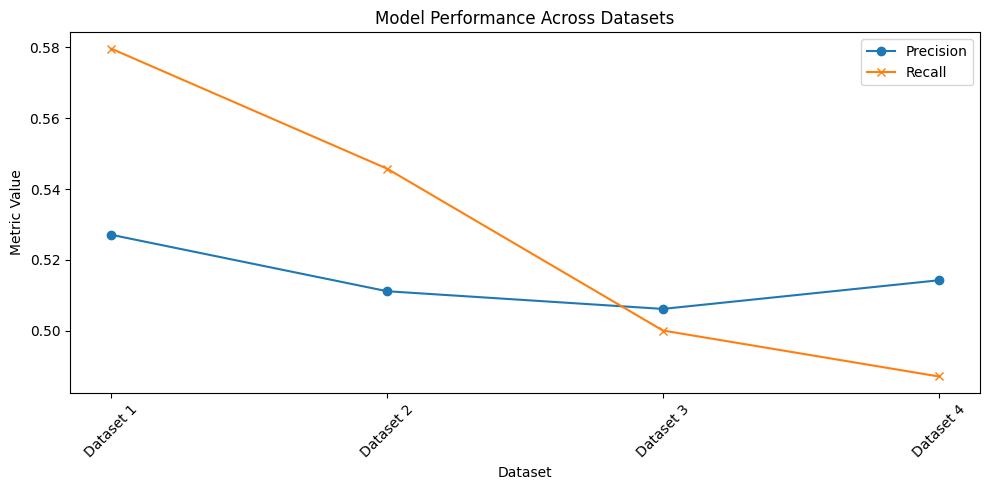

In [14]:
import matplotlib.pyplot as plt


precisions = []
recalls = []

for file_path in file_paths:
    data = np.load(file_path)
    precisions.append(np.mean(data['precision']))
    recalls.append(np.mean(data['recall']))

# Simple plot of precision and recall
plt.figure(figsize=(10, 5))
plt.plot(precisions, label='Precision', marker='o')
plt.plot(recalls, label='Recall', marker='x')
plt.title('Model Performance Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Metric Value')
plt.legend()
plt.xticks(range(len(file_paths)), labels=[f"Dataset {i+1}" for i in range(len(file_paths))], rotation=45)
plt.tight_layout()
plt.show()
